# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [1]:
import dill as pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import jit, prange
import os   

In [2]:
with open(os.path.join(os.getcwd(), '../../scenario_properties_short.pkl'), 'rb') as f:
    scenario_properties = pickle.load(f)

In [4]:
equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
drag_flattened = [scenario_properties.full_Cdot_PMD[i, j] for j in range(scenario_properties.full_Cdot_PMD.cols) for i in range(scenario_properties.full_Cdot_PMD.rows)]

# Now lambdify the equations
equations = [sp.lambdify(scenario_properties.all_symbolic_vars, eq) for eq in equations_flattened]
drag = [sp.lambdify(scenario_properties.all_symbolic_vars, eq) for eq in drag_flattened]

In [5]:
full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [25]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)

    print(t)
    # Iterate over each component in N
    for i in range(len(N)):
       
        # Compute and add the external modification rate, if applicable
        # Now using np.interp to calculate the increase
        # if full_lambda[i] is not None:
        #     increase = np.interp(t, times, full_lambda[i])
        #     # If increase is nan set to 0
        #     if np.isnan(increase):
        #         increase = 0
        #         dN_dt[i] += increase
        #     else:
        #         dN_dt[i] += increase

        # Compute the intrinsic rate of change from the differential equation
        dN_dt[i] += equations[i](*N)

        #print(i, N[i], dN_dt[i])
    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                   args=(full_lambda_flattened, drag), 
                   t_eval=scenario_properties.scen_times, method='BDF', max_step=1, rtol=1e-4, atol=1e-4)

0.0
0.010397468909715274
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [24]:
scenario_properties.full_drag[: , 5]

Matrix([
[          -128.683816415849*N_6kg_1 + 128.976917882587*N_6kg_2],
[           -57.4616106953938*N_6kg_2 + 57.591896761431*N_6kg_3],
[          -29.0703333123375*N_6kg_3 + 29.1359486296783*N_6kg_4],
[          -15.3305671459187*N_6kg_4 + 15.3650146167596*N_6kg_5],
[           -8.7818218231715*N_6kg_5 + 8.80146611644399*N_6kg_6],
[          -5.02178224074003*N_6kg_6 + 5.03296556777707*N_6kg_7],
[          -2.86662816354697*N_6kg_7 + 2.87298373328529*N_6kg_8],
[          -1.70625635370556*N_6kg_8 + 1.71002257576129*N_6kg_9],
[          1.02969352343406*N_6kg_10 - 1.02743563102703*N_6kg_9],
[      -0.628805861648734*N_6kg_10 + 0.630181678330862*N_6kg_11],
[      -0.389314542528328*N_6kg_11 + 0.390162644947601*N_6kg_12],
[      -0.243838554281789*N_6kg_12 + 0.244367440170818*N_6kg_13],
[       -0.152721446033862*N_6kg_13 + 0.15305126812083*N_6kg_14],
[    -0.0964906418572937*N_6kg_14 + 0.0966981299164054*N_6kg_15],
[    -0.0636863556247657*N_6kg_15 + 0.0638227167411957*N_6kg_16],
[

['Su_260kg', 'Su_473kg', 'sns', 'N_0.00141372kg', 'N_0.567kg', 'N_6kg', 'N_260kg', 'N_473kg']


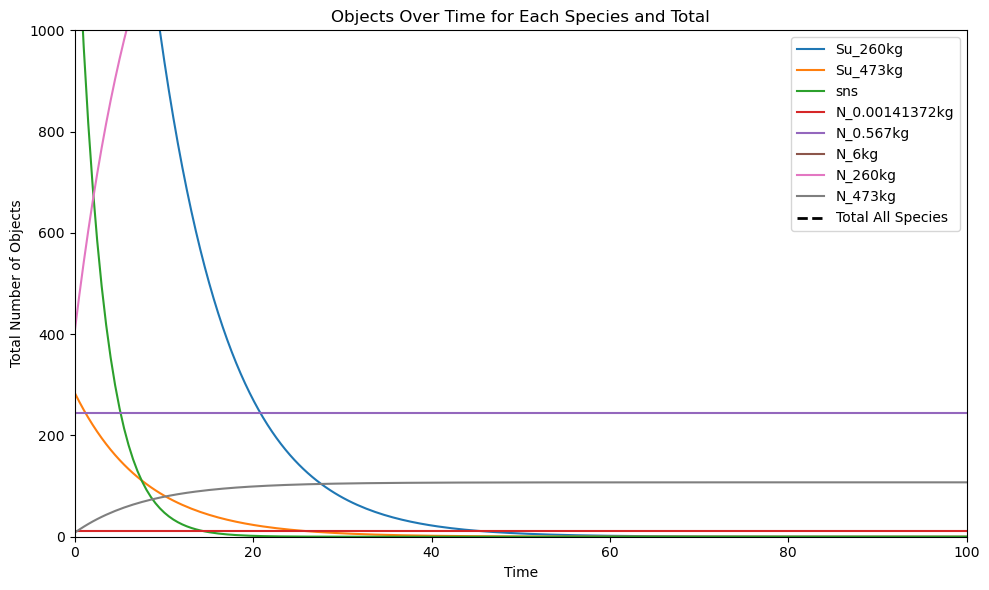

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names is available
species_names = scenario_properties.species_names
print(species_names)

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
# Adjust the ylim based on the range of total_objects_all_species if necessary
# plt.ylim(0, np.max(total_objects_all_species) * 1.1)
plt.ylim(0, 1000)

plt.legend()
plt.tight_layout()
plt.show()

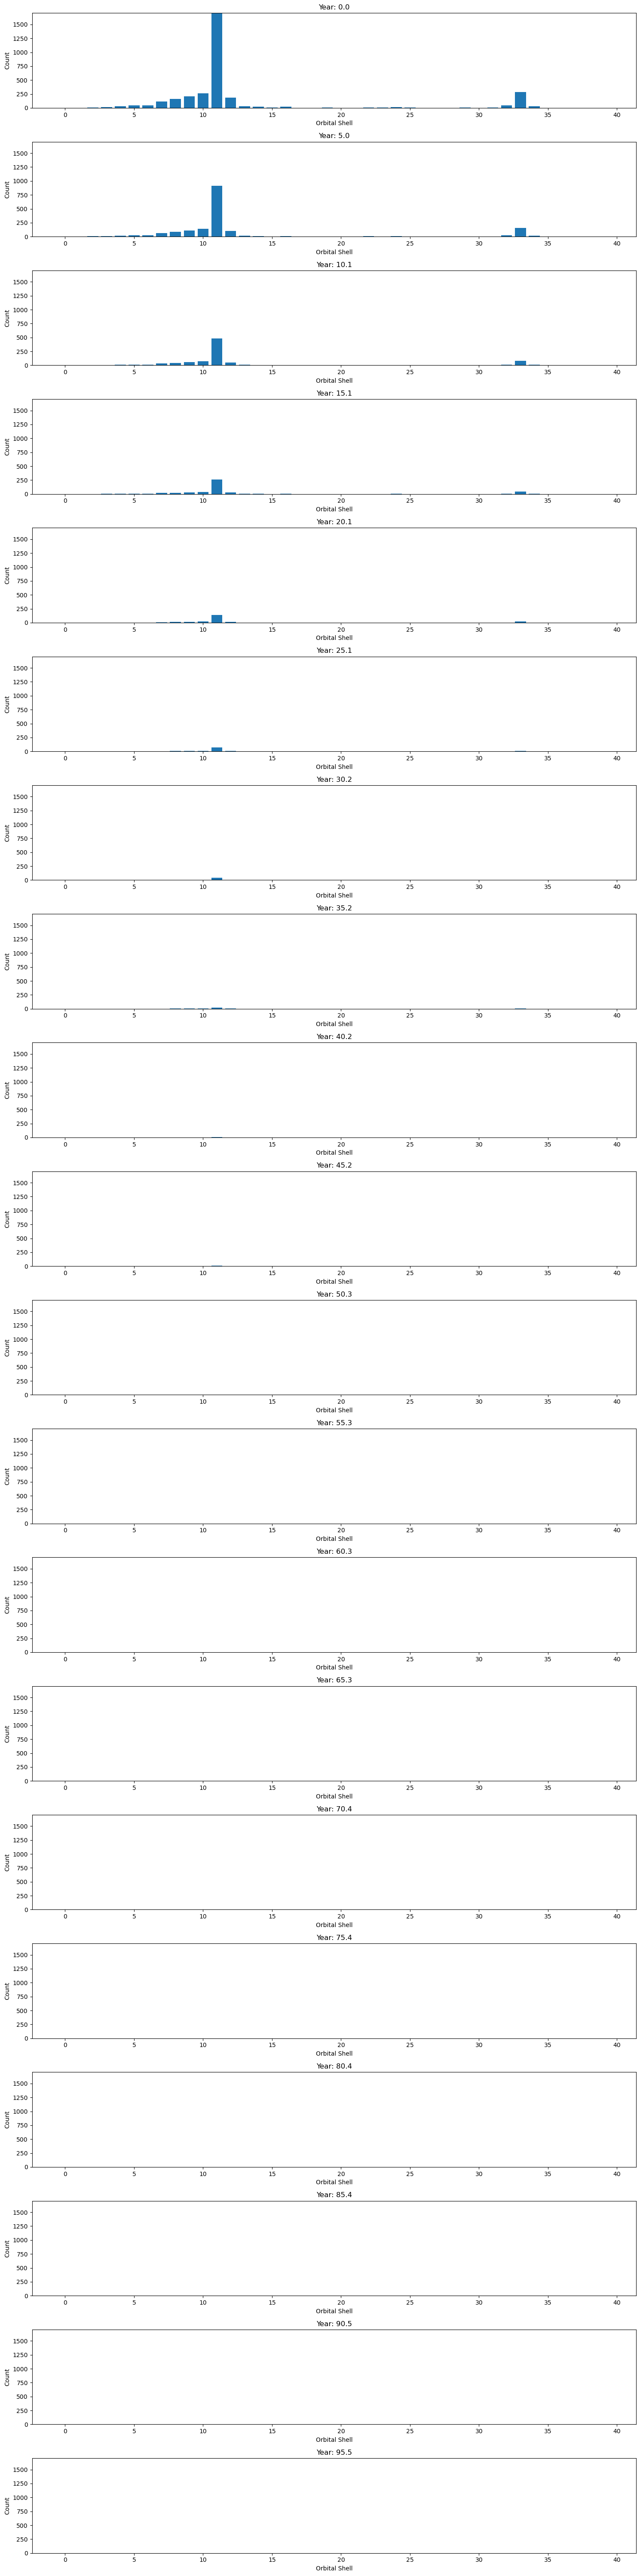

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

# Assuming the first species is of interest
species_index = 0  # Adjust as needed for different species
num_shells = 40
time_points = output.t
species_data = output.y  # Adjust if the shape of output.y differs
interval_years = 1
interval_steps = 2  # Adjust this to match the interval of 5 years according to your data

# Calculate indices to plot every 5 years
indices_to_plot = range(0, len(time_points), interval_steps)

# Folder to store the frames
frames_folder = 'frames'
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

filenames = []

# Generate a plot for each selected time slice
for i, idx in enumerate(indices_to_plot):
    plt.figure(figsize=(10, 6))
    species_slice = species_data[species_index*num_shells:(species_index+1)*num_shells, idx]
    plt.bar(range(num_shells), species_slice)
    plt.title(f'Species Index: {species_index}, Year: {round(time_points[idx], 1)}')
    plt.xlabel('Orbital Shell')
    plt.ylabel('Count')
    plt.ylim(0, np.max(species_data))  # Adjust as per your data
    
    # Save each figure as an image file
    filename = f'{frames_folder}/frame_{i}.png'
    plt.savefig(filename)
    plt.close()
    filenames.append(filename)

# Create the GIF
with imageio.get_writer('species_evolution.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optionally, remove the image files after creating the GIF
for filename in filenames:
    os.remove(filename)